# Test of KeldyshED

## Hamiltonian

In [1]:
import Test.@test

import KeldyshED; op = KeldyshED.Operators;

In [2]:
U = 2
H = U * (op.n("up") - 1/2) * (op.n("do") - 1/2) 

#V = -0.1
#H += V * (op.c_dag("up") * op.c("do") + op.c_dag("do") * op.c("up")) 
#B = 0.25
#H += B * (op.n("up") - op.n("do"))

0.5 + -1.0*c†("do")c("do") + -1.0*c†("up")c("up") + 2.0*c†("do")c†("up")c("up")c("do")

## Diagonalization and many-body density matrix

Ideas:

- Infer the set of indices `soi` from the Hamiltonian `H`?
- Compute of expectation values from the density matrix $\langle \hat{O} \rangle = \text{Tr} [ \rho \hat{O} ]$

In [3]:
import KeldyshED: EDCore
import KeldyshED.Hilbert: SetOfIndices

soi = SetOfIndices([["up"], ["do"]]);
ed = EDCore(H, soi)

Dimension of full Hilbert space: 4
Number of invariant subspaces: 4
  Subspace 1, dim = 1
    Basis Fock states: UInt64[0x0000000000000001]
    Energy levels: [0.0]
  Subspace 2, dim = 1
    Basis Fock states: UInt64[0x0000000000000002]
    Energy levels: [0.0]
  Subspace 3, dim = 1
    Basis Fock states: UInt64[0x0000000000000000]
    Energy levels: [1.0]
  Subspace 4, dim = 1
    Basis Fock states: UInt64[0x0000000000000003]
    Energy levels: [1.0]
Ground state energy: -0.5


In [4]:
import KeldyshED: density_matrix

β = 10.
ρ = density_matrix(ed, β)

# Todo: Compute density n

4-element Array{LinearAlgebra.Diagonal{Float64,Array{Float64,1}},1}:
 [0.4999773010656489]
 [0.4999773010656489]
 [2.26989343512172e-5]
 [2.26989343512172e-5]

## Kadanof-Baym contour single-particle Green's function

In [5]:
using Keldysh
contour = twist(Contour(full_contour, tmax=30., β=β));
grid = TimeGrid(contour, npts_real=100, npts_imag=100);

In [6]:
import Keldysh: get_beta
@test β == get_beta(grid, nothing);
@test β == length(get_branch(grid.contour, imaginary_branch));

In [7]:
import KeldyshED: computegf
import KeldyshED.Hilbert: IndicesType

u = IndicesType(["up"])
d = IndicesType(["do"])

g = computegf(ed, grid, [(d, d)], β)[1];

In [8]:
import Keldysh: density
# Todo: compare with density from ρ
@test all(density(g) .≈ 0.5);
density(g)[1]

0.5000000000000001 - 0.0im

## Pseudo-Particle Green's function

Trivial implementation computing the bare pseudo-particle Green's function (ppgf) as

$$
\hat{G}_0(z, z') = \exp \left[ - i (z - z') \hat{H} \right]
$$

where $z$ and $z'$ are contour times on any/all of the branches of the contour.

**Ideas**

- Extend TimeGF to handle *matrix valued Green's functions*? Here we work with scalar valued Green's functions keeping track of sector and state indices in outer array structure.
- Implement formally correct pseud-particle Green's function form?
  - Where $\hat{G}^R(t, t') = \hat{G}^>(t, t')$ after making projection to physical Fock space. 
  - This gives the boundary conditions $\hat{G}^>(t, t) = -i \mathbf{1}$ and $ \hat{G}^<(t, t) = \rho(t)$)

In [9]:
import Keldysh: TimeGF

# Bare pseudo-particle Green's function (atomic propagator) G0 
# (array over subspaces of arrays over subspace-fockstate cartesian product of TimeGFs)

# There must be a better way to initialize this beast...

G0 = [ Array{TimeGF, 2}(undef, length(s), length(s)) for s in ed.subspaces ]

for g0 in G0
    for i in eachindex(g0)
        g0[i] = TimeGF(grid)
    end
end

In [10]:
import LinearAlgebra: Diagonal
import KeldyshED: energies, partition_function

# Compute atomic propagator for all times

Z = partition_function(ed, β)
λ = log(Z) / β # Pseudo-particle chemical potential (enforcing Tr[G0(β)]=Tr[ρ]=1)

for (sidx, E) in enumerate(energies(ed))
    for t1 in grid, t2 in grid
        Δt = t1.val.val - t2.val.val
        g0 = Diagonal(exp.(-1im * Δt * (E .+ λ)))
        for I in eachindex(G0[sidx], g0)
            G0[sidx][I][t1, t2] = g0[I]
        end
    end
end

In [11]:
t_0, t_beta = branch_bounds(grid, imaginary_branch)

for (sidx, (G0_s, ρ_s)) in enumerate(zip(G0, ρ))
    for I in eachindex(G0_s)
        println("$I, $(G0_s[I][t_beta, t_0])")
    end
end

1, 0.4999773010656489 - 0.0im
1, 0.4999773010656489 - 0.0im
1, 2.2698934351217218e-5 - 0.0im
1, 2.2698934351217218e-5 - 0.0im


In [12]:
import KeldyshED: density_matrix

ρ = density_matrix(ed, β)

t_0, t_beta = branch_bounds(grid, imaginary_branch)

for (sidx, (G0_s, ρ_s)) in enumerate(zip(G0, ρ))
    G0_s_beta = Matrix{ComplexF64}(undef, size(ρ_s)...)
    for I in eachindex(G0_s, G0_s_beta)
        G0_s_beta[I] = G0_s[I][t_beta, t_0]
    end        
    @test ρ_s ≈ G0_s_beta
end

# Visualization

In [13]:
import PyCall; PyCall.pygui(:tk);
import PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/hugstr/.julia/packages/PyPlot/XHEG0/src/init.jl:192


In [14]:
extent = nothing
function plot2d(data; extent = nothing)
  # Correct for Row major order in Julia vs Column major in Python
  data = transpose(data)
  opt = Dict(:cmap=>"RdBu", :vmin=>-1., :vmax=>1., :origin=>"lower", :extent=>extent)
  plt.subplot(1, 2, 1)
  plt.imshow(real(data); opt...)
  plt.subplot(1, 2, 2)
  plt.imshow(imag(data); opt...)
  return
end;

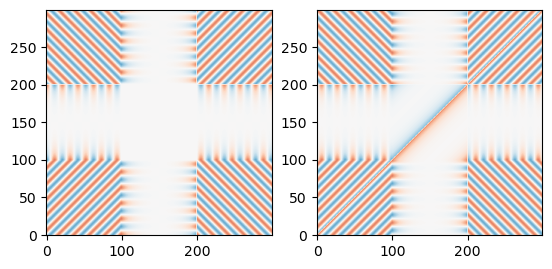

In [15]:
plot2d(g.data)

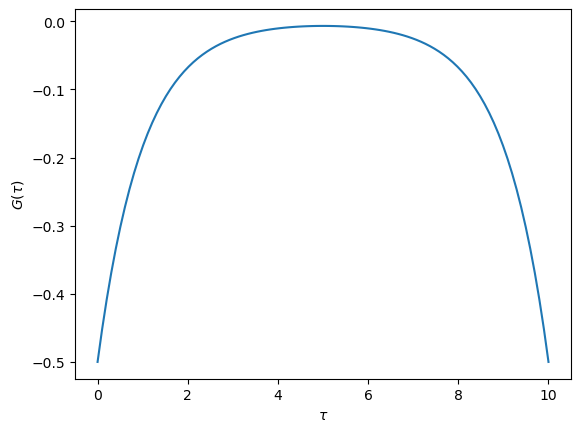

In [16]:
τ = imagtimes(grid)
g_τ = g[:matsubara]

plt.plot(τ, imag(g_τ))
plt.xlabel(plt.L"$\tau$");
plt.ylabel(plt.L"$G(\tau)$");

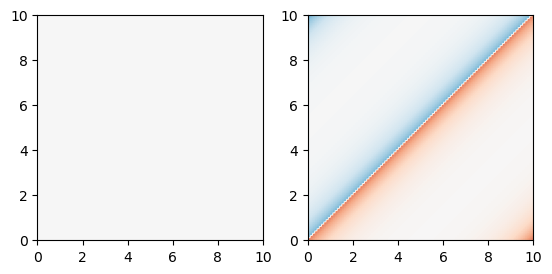

In [17]:
g_ττ = g[imaginary_branch, imaginary_branch];

plot2d(g_ττ, extent=[0, β, 0, β])

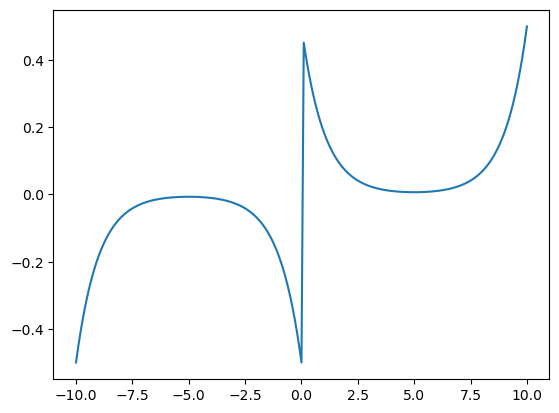

In [18]:
β = τ[end]

τ_ext = vcat(-β .+ τ, τ)
g_τ_ext = imag(vcat(g_ττ[end, :], g_ττ[1, :]))

plt.plot(τ_ext, g_τ_ext);

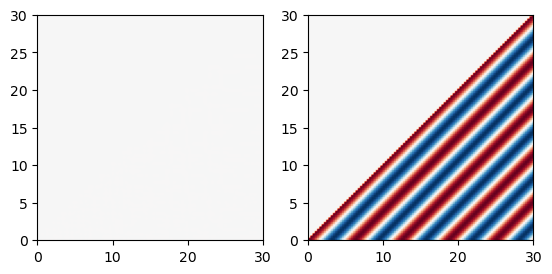

In [19]:
t = realtimes(grid)
t_max = t[end]

g_R = g[:retarded]
plot2d(g_R, extent=[0, t_max, 0, t_max])

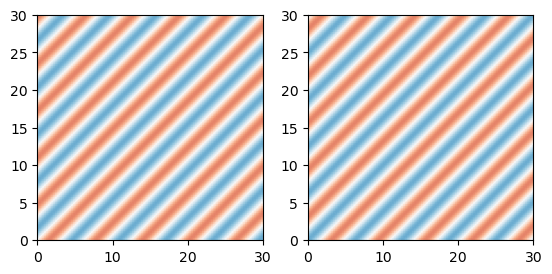

In [20]:
g_les = g[:lesser]
plot2d(g_les, extent=[0, t_max, 0, t_max])

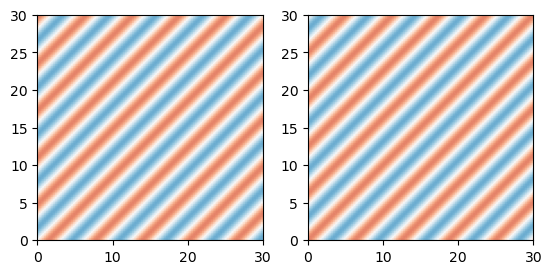

In [21]:
g_gtr = g[:greater]
plot2d(g_gtr, extent=[0, t_max, 0, t_max])

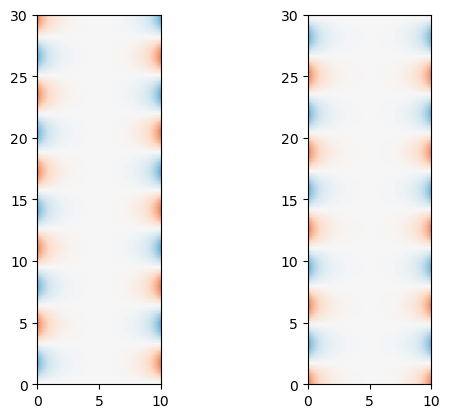

In [22]:
plot2d(g[imaginary_branch, forward_branch], extent=[0, β, 0, t_max])

# Green's function symmetries

In [23]:
import LinearAlgebra.I

g_fb = g[forward_branch,  backward_branch]
g_ff = g[forward_branch,  forward_branch ]
g_bf = g[backward_branch, forward_branch ]
g_bb = g[backward_branch, backward_branch]

@test g_ff - conj(g_bb) ≈ -im*I # Only at particle-hole symmetry?
@test g_fb ≈ conj(g_bf)

g_fi = g[forward_branch,  imaginary_branch]
g_bi = g[backward_branch, imaginary_branch]
g_if = g[imaginary_branch, forward_branch ]
g_ib = g[imaginary_branch, backward_branch]

@test g_fi ≈ g_bi 
@test g_if ≈ g_ib
@test g_fi ≈ -transpose(g_if)
@test g_bi ≈ -transpose(g_ib)

Test Passed